# Fraudulent Job Postings

In [1]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np
import missingno

#Data Visualization 
import seaborn as sns
import folium
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# sklearn
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix


#Preprocessing
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


#Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


#Data Evaluation 
from imblearn.over_sampling import SMOTE

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')


## Data Understanding

In [183]:
df = pd.read_csv('fake_job_postings.csv', index_col=0)
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


<AxesSubplot:>

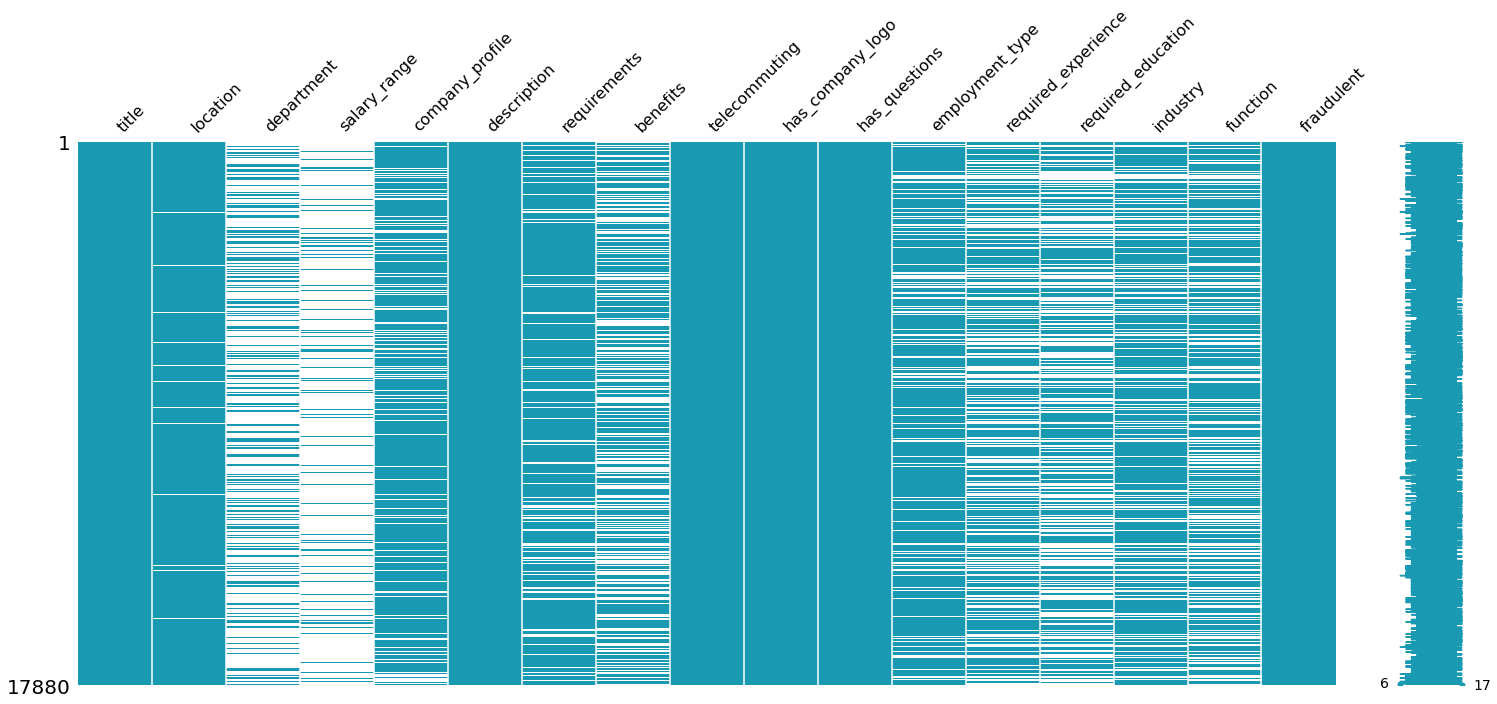

In [184]:
# checking missing data in our dataframe.
missingno.matrix(df,color=(0.1, 0.6, 0.7))

- oh wow lots of missing values

### Target
- Fraudulent

In [185]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

- First Row

In [186]:
#
df['has_benefit'] = pd.notnull(df["benefits"])
df['has_requirements'] = pd.notnull(df["requirements"])
df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements
job_id,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True


## Data Prep

In [187]:
df.location.isna().sum()

346

In [188]:
# Location
df['location'] = df['location'].fillna('  ')
df['location'] = df['location'].apply(lambda x: x[:2] )

In [189]:
df['location'].value_counts()

US    10656
GB     2384
GR      940
CA      457
DE      383
      ...  
JM        1
GH        1
CM        1
AL        1
SI        1
Name: location, Length: 91, dtype: int64

- Oh well, prob not even important 

In [225]:
df.company_profile[5]

'SpotSource Solutions LLC is a Global Human Capital Management Consulting firm headquartered in Miami, Florida. Founded in January 2012, SpotSource has created a fusion of innovative service offerings to meet the increasing demand of today’s economy. We specialize in Talent Acquisition, Staffing, and Executive Search Services across various functions and in specific industries. Global Talent Transfusion (GTT) services utilize best in practice qualification standards to deliver talent in temporary, temporary-to-hire, and permanent basis. Health Career Transition (HCT) is a subsidiary of Global Talent Transfusion and offers placement services specifically in the growing Healthcare arena. SpotSource Executive Search (SES) Consultants are special breed talent evangelists that understand how to advise and streamline the human resources process in the direction your organization requires for long term sustainability and success.\xa0Succession Planning. Leadership Development Programs. Compen

### Dealing with missing values from requirements and benefits

In [190]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_benefit', 'has_requirements'],
      dtype='object')

In [191]:
df.benefits[2]

'What you will get from usThrough being part of the 90 Seconds team you will gain:experience working on projects located around the world with an international brandexperience working with a variety of clients and on a large range of projectsopportunity to drive and grow production function and teama positive working environment with a great teamPay$40,000-$55,000Applying for this role with a VIDEOBeing a video business, we understand that one of the quickest ways that we can assess your suitability for this role, and one of the quickest ways that you can apply for it, is for you to submit a 60-90 second long video telling us about yourself, your experience and why you think you would be perfect for the role. \xa0It’s not about being a filmmaker or making a really creative video. \xa0A simple video filmed with a smart phone or web cam will be fine. Please also include where you are based and when you can start.You can upload the video onto YouTube or Vimeo (or similar) as a Draft or Li

In [229]:
# Fill nulls with 'no benefit listed'
df['benefits'] = df['benefits'].fillna('no benefit listed')

# Fill nulls with 'no requirement listed'
df['requirements'] = df['requirements'].fillna('no requirement listed')

# Fill nulls with 'no description listed'
df['description'] = df['description'].fillna('no description listed')

# Fill nulls with 'no required_experience listed'
df['required_experience'] = df['required_experience'].fillna('unknown')

# Fill nulls with 'no required_experience listed'
df['company_profile' ]= df['company_profile'].fillna('unknown')



In [231]:
df.company_profile.isna().sum()

0

 ### Combining our text data in a single column to start the cleaning  process

In [232]:
# 
df['text'] = '  '+ df['title'] +'  '+ df['description'] +'  '+ df['requirements']+'  '+ df['benefits']+'  '+ df['required_experience'] + '  '+ df['company_profile' ] + '  '
df.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements,text
job_id,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,US,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,no benefit listed,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True,"Marketing Intern Food52, a fast-growing, Ja..."
2,Customer Service - Cloud Video Production,NZ,Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,True,True,Customer Service - Cloud Video Production O...


In [233]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = df[df.fraudulent==1].text
actual_jobs_text = df[df.fraudulent==0].text

In [234]:
actual_jobs_text

job_id
1          Marketing Intern  Food52, a fast-growing, Ja...
2          Customer Service - Cloud Video Production  O...
3          Commissioning Machinery Assistant (CMA)  Our...
4          Account Executive - Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE: Itemization ...
                               ...                        
17876      Account Director - Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer - Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we?Vend ...
Name: text, Length: 17014, dtype: object

In [235]:
fraud_jobs_text

job_id
99         IC&E Technician  IC&amp;E Technician | Baker...
145        Forward Cap.  The group has raised a fund fo...
174        Technician Instrument & Controls   Technicia...
181        Sales Executive  Sales Executive  Sales Exec...
216        IC&E Technician Mt Poso  IC&amp;E Technician...
                               ...                        
17828      Student Positions Part-Time and Full-Time.  ...
17829      Sales Associate  LEARN TO EARN AN EXECUTIVE ...
17830      Android Developer  inFullMobile Sp. z o.o. i...
17831      Payroll Clerk   JOB DESCRIPTIONWe are seekin...
17832      Furniture mover  earn $500 to $1000 a week a...
Name: text, Length: 866, dtype: object

In [236]:
actual_jobs_text.value_counts().sum()

17014

In [237]:
fraud_jobs_text.value_counts().sum()

866

# WordCloud

## Fraudulent Words!!!  X

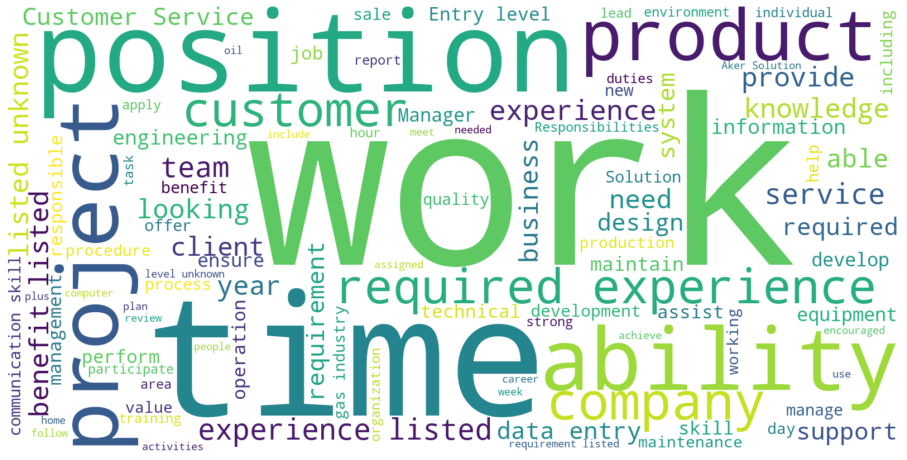

In [238]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`

## Not Fraudulent Words! lol ✓

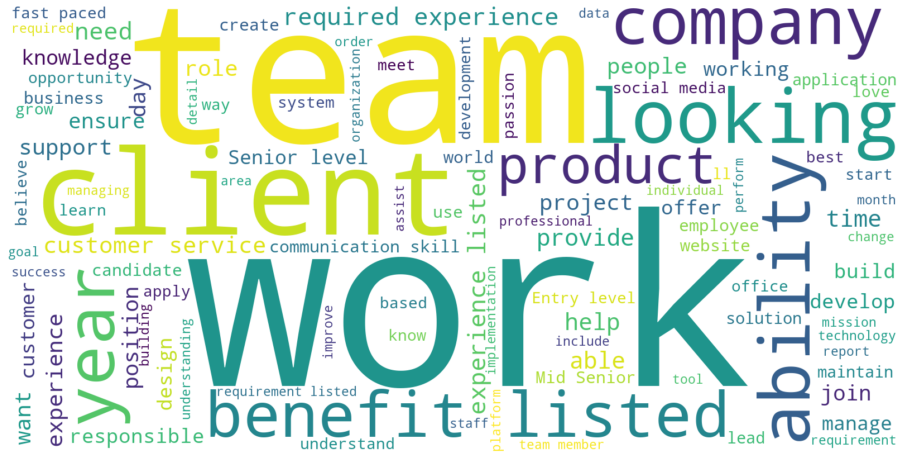

In [239]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

## Data Cleaning

In [240]:
# only need target and text
data = df[["fraudulent", "text"]]
data

,fraudulent,text
job_id,,
1,0,"Marketing Intern Food52, a fast-growing, Ja..."
2,0,Customer Service - Cloud Video Production O...
3,0,Commissioning Machinery Assistant (CMA) Our...
4,0,Account Executive - Washington DC THE COMPA...
5,0,Bill Review Manager JOB TITLE: Itemization ...
...,...,...
17876,0,Account Director - Distribution Just in ca...
17877,0,Payroll Accountant The Payroll Accountant w...
17878,0,Project Cost Control Staff Engineer - Cost C...


In [241]:
data.text.isna().sum()

0

Trying with Spacy

In [202]:
# Taken from: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/


In [203]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [204]:
print(punctuations)
print(nlp)
print(parser)
print(stop_words)


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
{'six', 'within', 'many', 'least', 'during', 'him', 'always', 'already', 'beforehand', 'were', 'towards', 'anyone', 'front', 'becomes', 'am', 'thereby', '’re', 'hereby', 'would', 'sixty', 'yourselves', 'empty', 'whatever', 'down', 'anywhere', 'off', 'everywhere', 'ca', 'with', "'s", 'around', 'fifteen', 'however', 'elsewhere', 'nor', 'their', 'for', 'another', 'among', 'say', 'whole', 'across', 'please', '’m', 'was', 'it', 'whereafter', 'much', 'none', 'because', 'does', 'hence', 'some', 'show', 'have', 'which', 'while', 'here', 'becoming', 'such', 'something', 'may', 'same', 'doing', 'except', 'amount', 'well', 'cannot', 'eleven', 'almost', 'how', 'should', 'by', 'next', 'thereafter', 'often', 'side', 'herein', 'from', 'besides', 'both', 'they', 'quite', 'if', 'anyway', 'myself', 'twelve', 'is', 'had', 'then', 'those', 'out', 'last', 'neither', 'seem', 'again', 'used', 'even', 'become', 'therein', 'others', 'us', 'me', '‘s', 'nine', 'throughout', "n't"

In [205]:
# displacy.render(df.text[1], style="dep", jupyter= True)

## Remove punctionation and numbers, and turn lowercase

In [242]:
def remove_punctuations(text):
    for punctuation in punctuations:
        text = text.replace(punctuation, ' ')
    return text


In [243]:
# Apply to the DF series
data.text = data.text.apply(remove_punctuations)

In [244]:
data.text

job_id
1          Marketing Intern  Food52  a fast growing  Ja...
2          Customer Service   Cloud Video Production  O...
3          Commissioning Machinery Assistant  CMA   Our...
4          Account Executive   Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE  Itemization ...
                               ...                        
17876      Account Director   Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer   Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we Vend ...
Name: text, Length: 17880, dtype: object

In [245]:
e = [list(range(0, 10)), "\xa0" ]
e

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], '\xa0']

In [246]:
#remove weird numbers
def remove_number(text):
    numbers_to_remove = ['1', '2', '3', '4', \
                         '5', '6', '7', '8', '9', '0', "\xa0" ]
    clean_text = text
    for num in numbers_to_remove:
        clean_text = clean_text.replace(num, ' ')
    
    return clean_text

In [247]:
data.text = data.text.apply(remove_number)
data.text


job_id
1          Marketing Intern  Food    a fast growing  Ja...
2          Customer Service   Cloud Video Production  O...
3          Commissioning Machinery Assistant  CMA   Our...
4          Account Executive   Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE  Itemization ...
                               ...                        
17876      Account Director   Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer   Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we Vend ...
Name: text, Length: 17880, dtype: object

- All punctuations removed, next turn all lowercase


In [248]:
data.text = data.text.str.lower()

In [249]:
data.text[108]

'  senior developer at a startup investment studio   forward partners invest in very early stage e commerce startups and help them to grow   we have an in house team of designers  marketers and product managers who work with the founders of these companies and guide them through their growth and development you might have heard of some of the companies we ve helped and invested in already   hailo  zopa  wool and the gang  thread  big health  stylect  makers academy   url  e  a   c      c       c eb   aedb   df b  a     ced       f       driftrock  top    snaptrip  loyalty bay and appear here we re looking for a skilled developer  who can make our entrepreneurs ideas a reality  you ll build prototypes  offer expert guidance and make suggestions for innovations all working in an agile fashion with the company founders and forward partners team   ideally  you ll comfortable making architectural choices and enjoy getting your hands dirty   you ll own every stage of coding  testing and depl

#### WordCloud Clean

In [252]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = data[data.fraudulent==1].text
actual_jobs_text = data[data.fraudulent==0].text

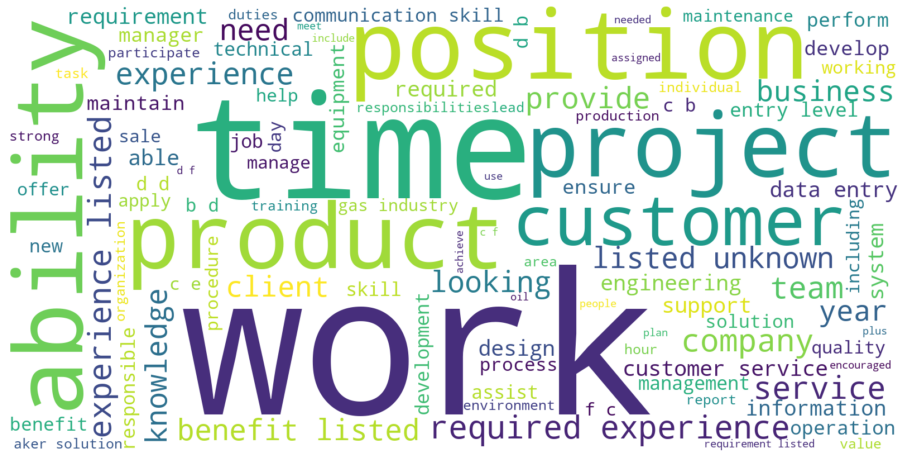

In [253]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

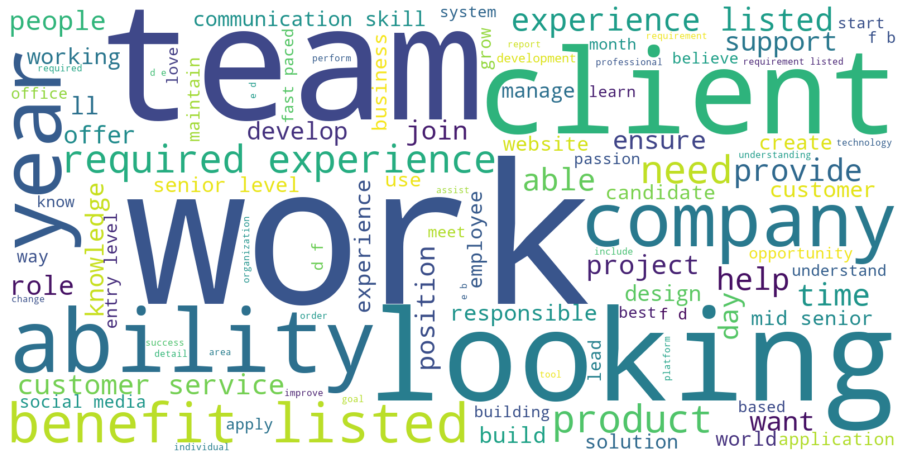

In [254]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               max_words = 100, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off");

In [216]:
# Custom transformer 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [217]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = word_tokenize, ngram_range=(1,3),lowercase=True)


In [218]:
bow_vector

CountVectorizer(ngram_range=(1, 3),
                tokenizer=<function word_tokenize at 0x7fed28b223a0>)

# Modelling

In [220]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, 
                                                    test_size=0.3)

In [63]:
y_train.value_counts()

0    11881
1      635
Name: fraudulent, dtype: int64

In [64]:
# smote = SMOTE(random_state=42)

In [65]:
# X_smote, y_smote = smote.fit_sample(X_train, y_train)

In [66]:
X_train

job_id
17812      agency sales managers               yr  we p...
5633       data warehouse etl architect  the primary ro...
48         customer service associate   the customer se...
9405       graduates  english teacher abroad  conversat...
13639      pre sales  solutions consultants solution en...
                               ...                        
14495      network engineer ii  summarya network engine...
13006      cleaner recruitment associate  about  url ff...
6771       project controls specialist  this position i...
12613      executive director  missionthe bayview hunte...
7122       web developer with angular js  the skill set...
Name: text, Length: 12516, dtype: object

In [68]:
#!python -m spacy download en_core_web_sm

In [69]:
from imblearn.under_sampling import RandomUnderSampler


In [74]:
clf = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', bow_vector),
                # ('under',RandomUnderSampler('majority',random_state=42)),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fecd3bd78b0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fed28b223a0>)),
                ('classifier', LogisticRegression())])

In [75]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print("Logistic Regression Recall:", recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9832214765100671
Logistic Regression Recall: 0.6320346320346321


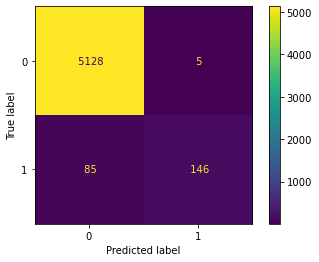

In [76]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')

## Oh boy XD XD XD

1. Random Forest

In [77]:
clf = RandomForestClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fecd18b2d60>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fed28b223a0>)),
                ('classifier', RandomForestClassifier())])

In [78]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9813571961222968
Random Forest Recall: 0.5757575757575758


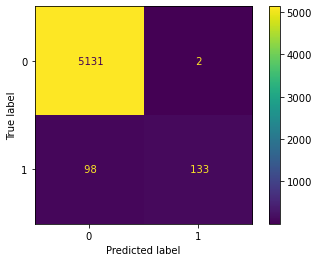

In [79]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      values_format=' ')

XGBoost Classifier

In [80]:
clf = XGBClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fecd3bb2d90>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fed28b223a0>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
            

In [81]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, predicted))
print("XGBoost Recall:", recall_score(y_test, predicted))

XGBoost Accuracy: 0.982475764354959
XGBoost Recall: 0.6233766233766234


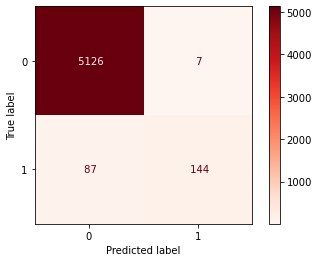

In [82]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')


# Try deal with imbalance

## Oversampling

In [134]:
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, cross_validate , GridSearchCV, cross_val_predict


# TfidfVectorizer

In [136]:
imb_log_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])

imb_log_results = cross_validate(imb_log_model,X_train,y_train,return_train_score=True)


In [133]:
imb_log_preds = cross_val_predict(imb_log_model,X_train,y_train)


In [137]:
# fitting the model
imb_log_model.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [138]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

XGBoost Accuracy: 0.9505965697240865
XGBoost Recall: 0.8037037037037037


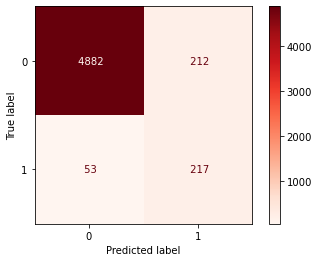

In [139]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

# bow_vector

In [140]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', bow_vector),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])

# imb_log_results = cross_validate(imb_log_model,X_train,y_train,return_train_score=True)



In [141]:
# imb_log_preds = cross_val_predict(imb_log_model,X_train,y_train)


In [142]:
# fitting the model
imb_log_model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7fed28b223a0>)),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [143]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9832214765100671
Recall: 0.737037037037037


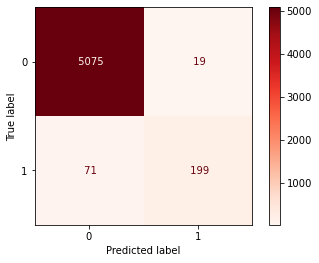

In [144]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

## CountVectorizer and over

In [221]:
imb_log_model = imbpipe(steps=[
                         ('vectorizer', CountVectorizer(stop_words=stop_words)),
                         ('over',RandomOverSampler(sampling_strategy='minority')),
                         ('LR',LogisticRegression(C=.1))])
# fitting the model
imb_log_model.fit(X_train,y_train)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('over', RandomOverSampler(sampling_strategy='minority')),
                ('LR', LogisticRegression(C=0.1))])

In [222]:
# Predicting with a test
predicted = imb_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.9729679343773303
Recall: 0.7722007722007722


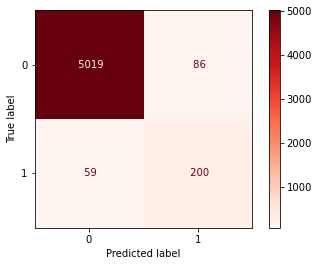

In [223]:
plot_confusion_matrix(imb_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

- CountVectorizer and over looks good

## Undersampling 

### TfidfVectorizer

In [147]:
under_log_model = imbpipe(steps=[
                         ('tfid',TfidfVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LR',LogisticRegression())])

# fitting the model
under_log_model.fit(X_train,y_train)


Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('LR', LogisticRegression())])

In [148]:
# Predicting with a test
predicted = under_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.8987695749440716
Recall: 0.8407407407407408


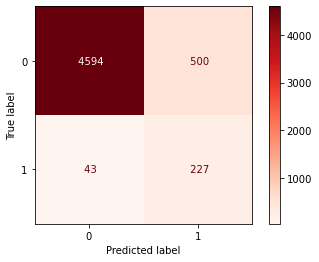

In [149]:
plot_confusion_matrix(under_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

- ouch that was pretty bad

## CountVectorizer

In [153]:
under_log_model = imbpipe(steps=[
                         ('tfid',CountVectorizer(stop_words=stop_words)),
                         ('under',RandomUnderSampler(sampling_strategy='majority')),
                         ('LR',LogisticRegression())])

# fitting the modela
under_log_model.fit(X_train,y_train)



Pipeline(steps=[('tfid',
                 CountVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another',
                                             'any', ...})),
                ('under', RandomUnderSampler(sampling_strategy='majority')),
                ('LR', LogisticRegression())])

In [151]:
# Predicting with a test
predicted = under_log_model.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, predicted))
print("Recall:", recall_score(y_test, predicted))

Accuracy: 0.8361297539149888
Recall: 0.8666666666666667


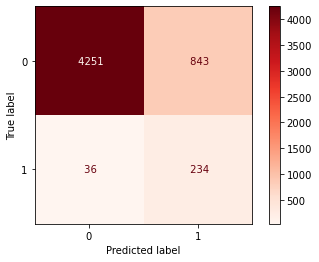

In [152]:
plot_confusion_matrix(under_log_model, 
                      X_test, y_test, 
                      cmap='Reds', 
                      values_format=' ')

# Lime

In [83]:
#!pip install lime

In [166]:
from lime import lime_tabular

In [167]:
df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements
job_id,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,US,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True


In [168]:
Lime = df[["fraudulent","has_benefit","has_requirements"]]
Lime.head(2)

,fraudulent,has_benefit,has_requirements
job_id,,,
1,0,False,True
2,0,True,True


In [169]:
X = Lime.drop(['fraudulent'], axis=1) # Features matrix
y = Lime['fraudulent']                # Target variable


In [170]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.02, random_state=42
)

In [171]:
RF = RandomForestClassifier(random_state=42)
output = RF.fit(X_train, y_train)
RF.score(X_test, y_test)

0.9692737430167597

In [172]:
# we can calculate predictions for confusion matrix
test_preds= RF.predict(X_test)
cm=confusion_matrix(y_test, test_preds)

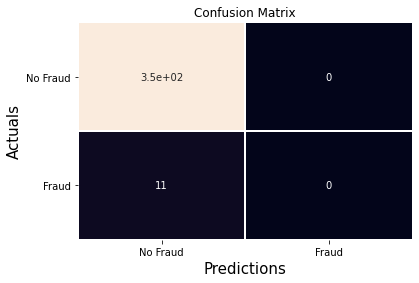

In [173]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, linewidths=1, cbar=False)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predictions', fontsize = 15)
ax.set_ylabel('Actuals', fontsize = 15)
ax.xaxis.set_ticklabels(['No Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['No Fraud', 'Fraud'], rotation = 0, fontsize = 10);

In [174]:
RF = RandomForestClassifier(random_state=42)
output = RF.fit(X_train, y_train)
RF.score(X_test, y_test)

0.9692737430167597

In [178]:
# explainer = lime_tabular.LimeTabularExplainer(
#  training_data=np.array(X_train),
#  feature_names=X_train,
#  class_names=[0, 1],
#  mode='classification'
# )

In [177]:
# i=15 # choosing one patient from X_test
# exp = explainer.explain_instance(
#  data_row = X_test.iloc[i], 
#  predict_fn=RF.predict_proba
# )
# exp.show_in_notebook(show_table=True)

In [95]:
# # only need target and text
# Lime = df[["fraudulent", "description","requirements","benefits"]]
# Lime

In [96]:
# # Apply to the DF series
# Lime.description = Lime.description.apply(remove_punctuations)
# Lime.benefits = Lime.benefits.apply(remove_punctuations)
# Lime.requirements = Lime.requirements.apply(remove_punctuations)


In [97]:
# Lime.description = Lime.description.str.lower()
# Lime.benefits = Lime.benefits.str.lower()
# Lime.requirements = Lime.requirements.str.lower()
